In [98]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import random
from sklearn.metrics.pairwise import cosine_similarity
import math
from tqdm import tqdm
from dateutil import tz
import matplotlib.pyplot as plt
%matplotlib inline

In [72]:
import psycopg2 as pg2
import psycopg2.extras as pgex
this_host='34.211.59.66'
this_user='postgres'
this_password='postgres'
conn = pg2.connect(host = this_host, 
                        user = this_user,
                        password = this_password)

sql_select = '''select created_at, location, tweet_content, cleaned_tweet, hashtags, date, time, date_time  
                from tweets where date_time >= NOW() - '1 day'::INTERVAL;'''

cur = conn.cursor(cursor_factory=pgex.RealDictCursor)
cur.execute(sql_select)
rows = cur.fetchall()
conn.close()
df = pd.DataFrame(rows)
df.reset_index(inplace = True)




In [73]:
df

,index,cleaned_tweet,created_at,date,date_time,hashtags,location,time,tweet_content
0,0,these new age rappers are ass and lame af. i d...,Fri Jun 09 03:42:15 +0000 2017,2017-06-09,2017-06-09 03:42:15,None,"carson, ca",03:42:15,these new age rappers are ass and lame af. i d...
1,1,"i just let out my loudest ""ahhhhhhhhh"" ever",Fri Jun 09 03:42:16 +0000 2017,2017-06-09,2017-06-09 03:42:16,None,"pico rivera, ca",03:42:16,"i just let out my loudest ""ahhhhhhhhh"" ever ht..."
2,2,better jan the original?,Fri Jun 09 03:42:17 +0000 2017,2017-06-09,2017-06-09 03:42:17,None,"los angeles, ca",03:42:17,better jan the original? https://t.co/ordh9eo3y3
3,3,there was no cover up and never has been and ...,Fri Jun 09 03:42:19 +0000 2017,2017-06-09,2017-06-09 03:42:19,None,"burbank, ca",03:42:19,@daboostr @hydraman40black @anncoulter @potus ...
4,4,prefect fucken shoot,Fri Jun 09 03:42:23 +0000 2017,2017-06-09,2017-06-09 03:42:23,None,"south gate, ca",03:42:23,prefect fucken shoot
5,5,guess where i'm at? in the clouds. dreams comi...,Fri Jun 09 03:42:23 +0000 2017,2017-06-09,2017-06-09 03:42:23,None,"los angeles, ca",03:42:23,guess where i'm at? in the clouds. dreams comi...
6,6,i feel so disrespected,Fri Jun 09 03:42:41 +0000 2017,2017-06-09,2017-06-09 03:42:41,None,"california, usa",03:42:41,i feel so disrespected https://t.co/lobwu9qxdu
7,7,ofmndkx,Fri Jun 09 03:44:30 +0000 2017,2017-06-09,2017-06-09 03:44:30,None,"los angeles, ca",03:44:30,ofmndkx
8,8,exactly renzo,Fri Jun 09 03:45:03 +0000 2017,2017-06-09,2017-06-09 03:45:03,None,"cerritos, ca",03:45:03,@schoolboyrenzo exactly renzo
9,9,crazy right?,Fri Jun 09 03:45:40 +0000 2017,2017-06-09,2017-06-09 03:45:40,None,"west hollywood, ca",03:45:40,@sancheezmo215 crazy right?


In [74]:
df['created_datetime'] = pd.to_datetime(df['created_at'])
df['year'] = df.created_datetime.apply(lambda x: x.year)
df['month'] = df.created_datetime.apply(lambda x: x.month)
df['day'] = df.created_datetime.apply(lambda x: x.day)
#df['dayofweek'] = df.created_datetime.apply(lambda x: x.dayofweek)
df['hour'] = df.created_datetime.apply(lambda x: x.hour)

In [75]:
import pickle
!pip install redis
import redis
redis_ip = '34.211.59.66'
r = redis.StrictRedis(redis_ip)

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [76]:
hastages_series = df['hashtags']

In [77]:
count_vectorizer = CountVectorizer(min_df = 1, stop_words='english')
hashtags_countvec_fit = count_vectorizer.fit(hastages_series)
hashtags_countvec = pickle.dumps(hashtags_countvec_fit)
r.set('hashtags_countvec_fit_temp', hashtags_countvec)

True

In [78]:
hashtags_countvec = pickle.loads(r.get('hashtags_countvec_fit_temp'))

In [79]:
time_delta = max(df['created_datetime']) - min(df['created_datetime'])
time_window = time_delta.components.days*24 + time_delta.components.hours
time_lag = timedelta(hours = 2)
time_gap = timedelta(hours = 1)
windows = int(round(time_delta/time_gap,0))
print('start time: ', min(df['created_datetime']),'\n',\
      'end time:  ', max(df['created_datetime']),'\n',\
      'total hours: ',time_window,'\n',\
      'time lag: ', time_lag,'\n',\
      'time gap: ', time_gap,'\n',\
      'time windows: ', windows)

start time:  2017-06-08 15:43:26 
 end time:   2017-06-09 05:51:17 
 total hours:  14 
 time lag:  2:00:00 
 time gap:  1:00:00 
 time windows:  14


In [130]:
time_delta = max(df['created_datetime']) - min(df['created_datetime'])
time_window = time_delta.components.days*24 + time_delta.components.hours
time_lag = timedelta(hours = 2)
time_gap = timedelta(hours = 1)
windows = int(round(time_delta/time_gap,0))
time_format = '%Y-%h-%d %a %I %p'
from_zone = tz.tzutc()
#to_zone = tz.tzlocal()
to_zone = 'US/Pacific'
def hashtag_trend(hashtag):
    hashtag = hashtag.lower()
    arr = []
    start_time = min(df['created_datetime'])
    for window in range(windows):
        start_time = start_time
        end_time = start_time + time_lag
        subset = df['hashtags'][((df['created_datetime'] < end_time) & (df['created_datetime'] > start_time))]
        h = subset.str.contains(hashtag).mean()
        arr.append(h)
        start_time += time_gap
    arr = np.array(arr)  
    
    grad = np.gradient(arr)
    tr = np.argwhere(grad>.01).reshape(1,-1)[0]
    spikes = []
    [spikes.append(i) for i in tr if (i-1) not in tr]
    plt.figure(figsize=(14,7))
    plt.plot(arr, label='Hashtag Frequency')
    plt.plot(grad, label='Frequency Slope')
    
    for i,j in enumerate(spikes):
        spiketime = (min(df['created_datetime']) + time_gap * j) 
        spiketime = spiketime.replace(tzinfo=from_zone)
        spiketime_et = spiketime.astimezone(to_zone)
        spiketime_et = spiketime_et.strftime(time_format)
        
        plt.axvline(j, color = 'r',linestyle='dashed', label = 'Trending: {}'.format(spiketime_et))
    plt.title(hashtag, fontsize=20)    
    plt.legend(fontsize=12)   
    return  

In [83]:
hashtag_name = hashtags_countvec.get_feature_names()
hashtag_name

['009',
 '0nceuponatime',
 '10',
 '100',
 '100dayproject',
 '100daysofjustdeandre',
 '100kpyramid',
 '100million',
 '100szn',
 '101',
 '1020',
 '106',
 '107',
 '108',
 '109',
 '10months',
 '10news',
 '10thplanetfightteam',
 '10x',
 '10xgrowthcon',
 '10yearsold',
 '11',
 '110',
 '110freeway',
 '11thhour',
 '12',
 '1200bucks',
 '1235',
 '125',
 '13218',
 '1371',
 '13clock',
 '13reasonswhy',
 '13thgrade',
 '14parkingtickets',
 '150th',
 '156',
 '15secondsofzen',
 '17',
 '1711',
 '176',
 '181',
 '183',
 '191',
 '1930s',
 '1980s',
 '1980sfashion',
 '1982',
 '1985',
 '1988',
 '1989streamingparty',
 '1990s',
 '1994',
 '1million',
 '1minutecover',
 '1stworldproblems',
 '1week',
 '2000spartyla',
 '2008',
 '2009',
 '2010',
 '2012',
 '2016elections',
 '2017',
 '2017ada',
 '2017btsfesta',
 '2017election',
 '2017graduates',
 '2017ncfcc',
 '2018',
 '2020',
 '20yearsstrong',
 '21',
 '21dayslimdown',
 '21massacre',
 '2257',
 '23',
 '240z',
 '24hourfitness',
 '24legacy',
 '27',
 '28',
 '29thfloor',
 '2

In [96]:
time_delta = max(df['created_datetime']) - min(df['created_datetime'])
time_window = time_delta.components.days*24 + time_delta.components.hours
time_lag = timedelta(hours = 2)
time_gap = timedelta(hours = 1)
windows = int(round(time_delta/time_gap,0))
time_format = '%Y-%h-%d %a %I %p'
from_zone = tz.tzutc()
#to_zone = tz.tzlocal()
to_zone = 'US/Pacific'
def hashtag_trend_t(hashtag):
    hashtag = hashtag.lower()
    arr = []
    start_time = min(df['created_datetime'])
    for window in range(windows):
        start_time = start_time
        end_time = start_time + time_lag
        subset = df['hashtags'][((df['created_datetime'] < end_time) & (df['created_datetime'] > start_time))]
        h = subset.str.contains(hashtag).mean()
        arr.append(h)
        start_time += time_gap
    arr = np.array(arr)  
    
    grad = np.gradient(arr)
    tr = np.argwhere(grad>.01).reshape(1,-1)[0]
    spikes = []
    [spikes.append(i) for i in tr if (i-1) not in tr]
    return subset, arr, grad, spikes

TypeError: 'mins' is an invalid keyword argument for this function

In [152]:
hashtag_name = hashtags_countvec.get_feature_names()
tag = []
for window in tqdm(range(windows)):
        start_time = start_time
        end_time = start_time + time_lag
        subset = df['hashtags'][((df['created_datetime'] < end_time) & (df['created_datetime'] > start_time))]
        for hashtag in hashtag_name:
            tag.append([window,hashtag,sum(subset.str.contains(hashtag))])

100%|██████████| 14/14 [03:58<00:00, 17.09s/it]


In [ ]:
hashtag_name = hashtags_countvec.get_feature_names()
tag = []
for hashtag in hashtag_name:
    for window in tqdm(range(windows)):
        start_time = start_time
        end_time = start_time + time_lag
        subset = df['hashtags'][((df['created_datetime'] < end_time) & (df['created_datetime'] > start_time))]
            tag.append([hashtag,window,sum(subset.str.contains(hashtag))])
            
            
            arr = np.array(arr)  
    
    grad = np.gradient(arr)
    tr = np.argwhere(grad>.01).reshape(1,-1)[0]

In [157]:
temp_hash_count_12hr = pickle.dumps(tag)
r.set('temp_hash_count_12hr', temp_hash_count_12hr)

True

In [162]:
temp_hash_count_12hr = pickle.loads(r.get('temp_hash_count_12hr'))

In [164]:
hash_count_12hr_df = pd.DataFrame(temp_hash_count_12hr, columns = ['window','hashtag','count'])

In [167]:
(hash_count_12hr_df.groupby(['hashtag'])['count'].sum())>0

hashtag
009                             False
0nceuponatime                   False
10                               True
100                              True
100dayproject                    True
100daysofjustdeandre            False
100kpyramid                     False
100million                      False
100szn                          False
101                             False
1020                            False
106                             False
107                              True
108                             False
109                             False
10months                        False
10news                          False
10thplanetfightteam             False
10x                             False
10xgrowthcon                    False
10yearsold                      False
11                              False
110                             False
110freeway                      False
11thhour                        False
12                              False
1200

In [ ]:
>> data.groupby(func, axis=0).mean()
>>> data.groupby(['col1', 'col2'])['col3'].mean()

In [91]:
subset, arr, grad, spikes = hashtag_trend_t('battery')

In [132]:
trend = np.array([trending[i][1] for i in range(len(trending))])
trending[np.argmax(trend)][1]

0.0052796769817823434

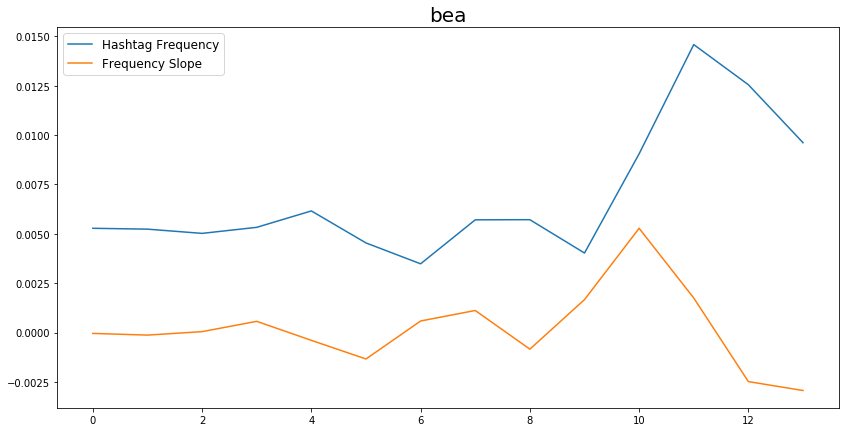

In [131]:
hashtag_trend('bea')

In [88]:
grad

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   5.60475283e-05,   1.11881853e-04,
        -1.56627343e-07,  -1.11881853e-04,   8.15418678e-06,
         1.06860440e-04,   8.56307050e-05])

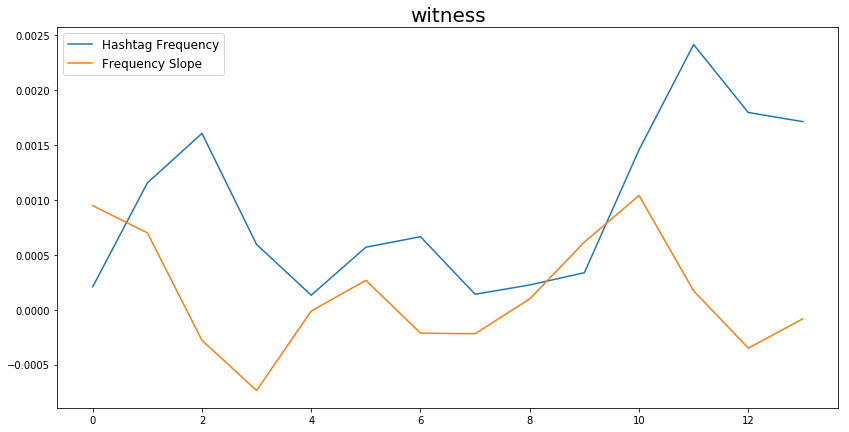

In [133]:
hashtag_trend('WITNESS')

In [88]:
np.argmax(nbafinals_grad).reshape(1,-1)[0]

array([124])

In [ ]:
nbafinals_grad[61]

In [80]:
nbafinals_grad[23]

0.046130180327304676

In [81]:
(np.argwhere(nbafinals_grad>.01).reshape(1,-1)[0])

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


array([23, 24, 94, 95, 96, 97])

In [82]:
spikes = []
tr = np.argwhere(nbafinals_grad>.01).reshape(1,-1)[0]
[spikes.append(i) for i in tr if (i-1) not in tr]
        
spikes        

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


[23, 94]

In [83]:
np.argmax(nbafinals)

125

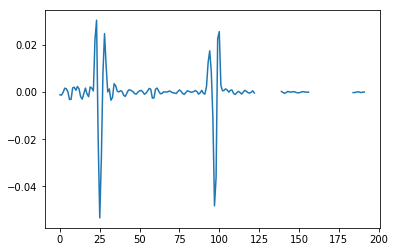

In [84]:
plt.plot(np.gradient(nbafinals_grad))

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


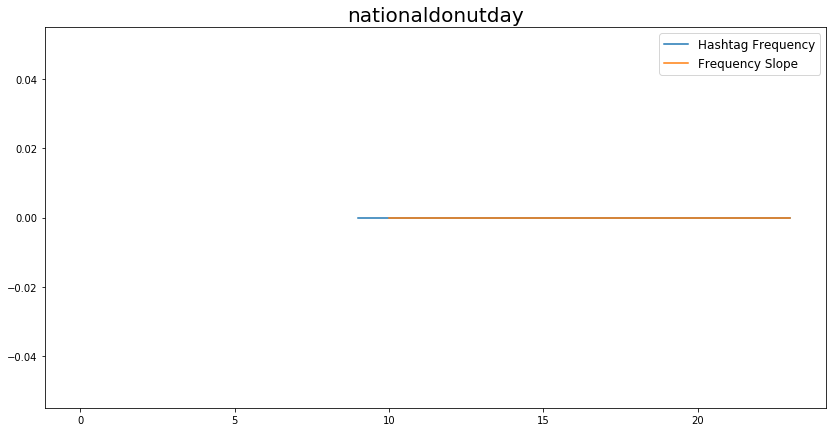

In [66]:
hashtag_trend('nationaldonutday')

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


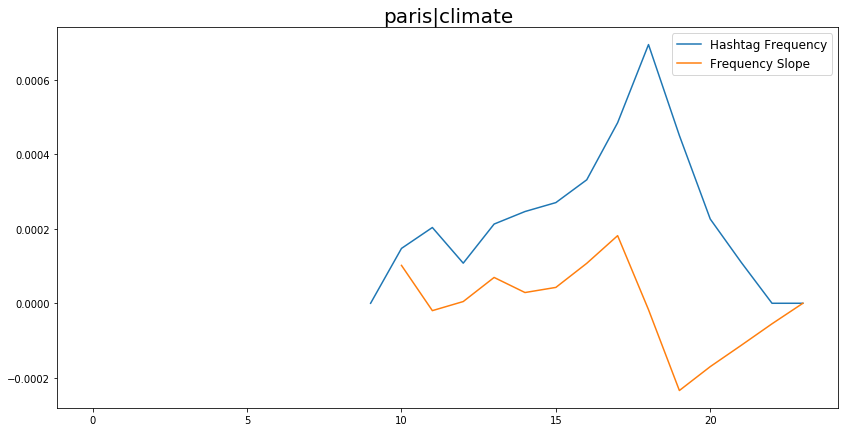

In [67]:
hashtag_trend('paris|climate')

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


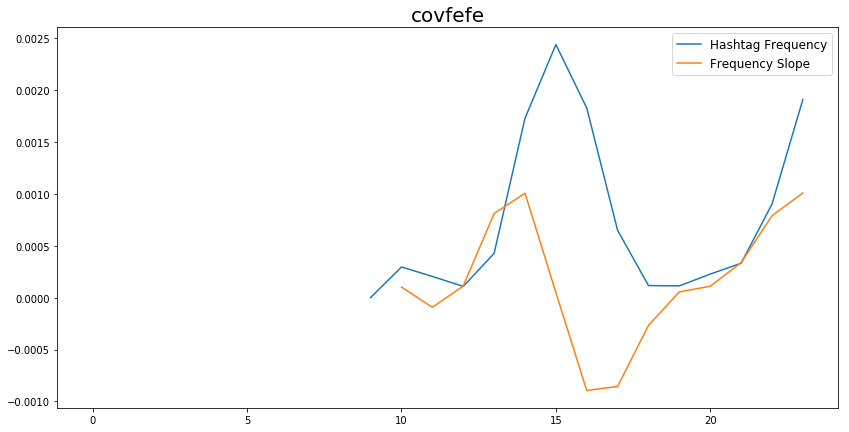

In [68]:
hashtag_trend('covfefe')

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


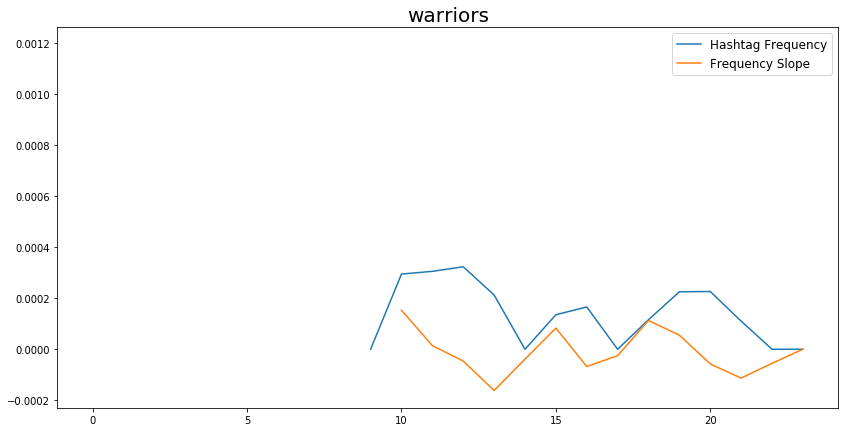

In [69]:
hashtag_trend('Warriors')

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


TypeError: 'NoneType' object is not iterable

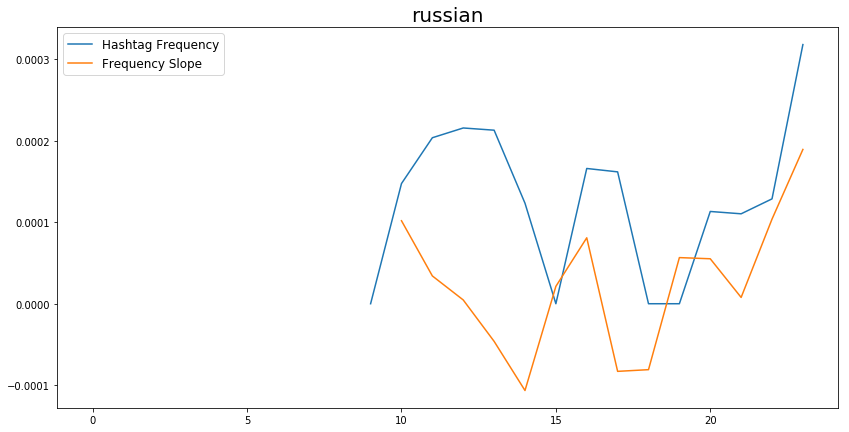

In [70]:
hashtag_trend('Russian')

In [ ]:
hashtag_trend('trump')

In [ ]:
hashtag_trend('china')